# [IAPR][iapr]: Project


**Group ID:** 32

**Author 1 (sciper):** Ghali CHRAIBI (262251)  
**Author 2 (sciper):** Yann Yasser HADDAD (272292)   
**Author 3 (sciper):** Julien BERGER (247179)   

**Release date:** 07.05.2021  
**Due date:** 03.06.2021 (23h59)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Imports 

In [23]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import skimage.io

from utils_segmentation import *

from MNISTDataset import MNISTDataset
from CNN import CNN

from utils import *
from MNIST_utils import extract_data, extract_labels
from ML_pipeline import augment_data, train_loop, test_loop, predict

---
## 0. Introduction

An anonymous researcher that we will name Lann Yecun is convinced that the MNIST dataset still has great potential. He decides to create a playing card game based on MNIST digits and different figures. The game uses a standard 52 card deck which is composed of four French suits/colours: clubs (&#9827;), diamonds (&#9830;), hearts (&#9829;) and spades (&#9824;). Each suit includes 10 digit cards (from 0 to 9) and 3 figures (Jack-J, Queen-Q, and King-K). Here is an example of the 13 spade cards with their name.


<img src="data/media/example_cards.png">


We can find the same arrangement of cards for the clubs, diamonds, and hearts. 


## 1. Rules


### 1.1 Standard

The rules are based on the simple battle card game. The goal of the game is to win as many points as possible. Each turn, the 4 players play a card in front of them. As displayed in the example below. The rules are the following:

- The cards are ranked in the following order : **0 < 1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9 < J < Q < K**.
- The player with the highest-ranked card wins the round and obtains **1 point**. 
- If the highest-ranked card is the same for multiple players we call it a draw and all winners get **1 points**. 
- In this configuration, we **do not** take into account the suits. The game only rely on the card ranks. 
- The game lasts 13 rounds. After the last round, the winner is the player that has the largest number of points. 
- In the example below Player 1 wins the round with his Queen ( 0 < 8 < J < **Q**).

If two or more players have the same number of points they share the victory.

### 1.2 Advanced

The advanced rules take into account the suits. 

- At the beginning of **each round** a random player is designated as the **dealer**. The dealer places a green token with the letter *D* next to him (player 1 in the example below).
- Only the cards that belong to the same suit as the one of the dealer are considered valid. In the example below, only Player 4 is competing with Player 1 as spade was selected by the dealer (e.i., Player 1). Player 2 and 3 are out for this round. Player 1 wins the round and **1 point** with the Queen ( 0&#9824; < **Q&#9824;**).
- There cannot be any draw between the players as they are not any card duplicates.
- We use the same system as the standard method to count the points.


<img src="data/media/example_round.jpg">


### 1.3 Notes

- The orientation of the card is linked to the position of the player around the table. For instance, to read the card of the 3rd player you will have to rotate it by 180°.
- The **digits** always **face** the players around the table. The figures can have random orientations.
- Player 1 **always** seats south of the table. The players are **always** ordered counter-clockwise as in the example. 
- The dealers can change between the rounds and games.
- Some cards **might** apear multiple times per game.
- Pictures are always taken from rougthly the same altitude.
- The digits from the training set **would not** be the same as the one of the testing set.

---
## 2. Data

You will be given the images of 7 games that were played ([download link](https://drive.google.com/drive/folders/1fEy27wnJsUJPRsEEomzoAtP56s-7HFtk?usp=sharing)). The data are composed of:
   - 7 folder named after the games (game1 to game7).
   - Each game includes 13 ordered images (1st to 13th round).
   - Each game includes a csv file with the ground truth of the game. The first row list the players (P1 to P4) as well as the dealer (D). The following rows represent the rounds (1 to 13). We represent the card played with 2 character as $AB$ where $A \in [0-9, J, Q, K]$ is the rank of the card and $B \in [C, D, H, S]$ is the suit. For example, QS means "(Q)ueen of (S)pade" and 0D means "(0) of (D)iamond". The dealer is represented by the ID of the player (e.g. P1 -> 1).
   
You are free to use external datasets such as the original MNIST train set that you used in lab 3.

### Data loading

In [2]:
train_data = 'data/train_games'
train_game_count = 7
game_round_count = 13

dict_data = {}

for i in range(1, train_game_count+1):
    # For each game, store the path of the csv and the image of each round
    dict_data[f'game{i}'] = {}
    dict_data[f'game{i}']['url'] = train_data + f'/game{i}'
    dict_data[f'game{i}']['csv'] = train_data + f'/game{i}.csv'
    
    for j in range(1, game_round_count+1):
        dict_data[f'game{i}'][f'round{j}'] = skimage.io.imread(train_data + f'/game{i}/{j}.jpg')

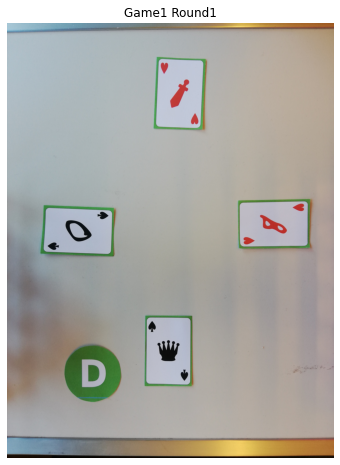

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.imshow(dict_data['game1']['round1'])
ax.set_title('Game1 Round1')
ax.axis('off')
plt.show()

# Extract ranks from cards

In [31]:
backup_rank = np.load("data/backup_rank.npy")
backup_suit = np.load("data/backup_suit.npy")

df_ranks, df_suits = extract_all_ranks_suits(dict_data, 7, 13, backup_rank, backup_suit)


df_ranks.to_pickle(f'data/classification_data/all_ranks.pickle')
df_suits.to_pickle(f'data/classification_data/all_suits.pickle')

---
## 3. Your Tasks

Your task is to ready yourself for the final evaluation. The day of the exam we will give you a new folder with a new game. ! The digits on the cards **differ** from the one of the traning set. When given a new data folder with 13 images your should be able to:

**Task 0**
   - Plot an overlay for each round image that shows your detections and classification. You can for example plot bounding boxes around the cards/dealer token and add a text overlay with the name of the classes.

**Task 1**
   - (a) Predict the **rank** of the card played by each player at each round (Standard rules).
   - (b) Predict the **number of points** of each player according to **Standard** rules
 
**Task 2**
   - (a) Detect which player is the selected **dealer** for each round.
   - (b) Predict the **rank** and the **suit** of the card played by each player at each round (Advanced rules).
   - (c) Predict the **number of points** of each player according to **Advanced** rules

---

**Before the exam (until 03.06.21 at 23h59)**
   - Create a zipped folder named **group_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam (04.06.21)**
   - You will be given a **new folder** with 13 images (rounds) and but **no ground truth** (csv file).
   - We will ask you to run your pipeline in **realtime** and to send us your prediction of task 1 and 2 that you obtain with the function **print_results**. 
   - On our side we will compute the perfomance of your classification algorithm. 
   - To evaluate your method we will use the **evaluate_game** function presented below. To understand how the provided functions work please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty the day of the exam**. 

## Full pipeline

In [ ]:
backup_rank = np.load("data/backup_rank.npy")
backup_suit = np.load("data/backup_suit.npy")

### Task 0

#### Import and visualizer data

In [ ]:
path_to_image_folder = "data/train_games/game_1/"
dict_data_test = {}
dict_data_test["game1"] = {}
for i in range(13):
    dict_data_test['game1'][f'round{i+1}'] = skimage.io.imread(f"{path_to_image_folder}/{i+1}.jpg")

####  Segment data and visualize results

It might not be fully representative of the final results.

In [ ]:
df_results = pipeline_segment_plot_game(dict_data_test, game_number=1)

#### Visualize cards

In [ ]:
visualize_extracted_cards(results_df)

#### Visualize dealers

In [ ]:
visualize_dealer(dict_data_test, game_number=1)

#### Scaled down ranks and suits

In [ ]:
for i in range(4):
    results_df[f"P{i+1}_rank"] = results_df[f"P{i+1}_extracted_card"].apply(lambda card: extract_rank_from_card(card[0], card[1], backup_rank))
    results_df[f"P{i+1}_suit"] = results_df[f"P{i+1}_extracted_card"].apply(lambda card: extract_suit_from_card(card[0], backup_suit, upper_left=True))

#### Predict ranks and suits

In [ ]:
model_rank_path = "data/models/model_rank.pt"
model_suit_path = "data/models/model_suit.pt"
model_class = CNN

In [ ]:
convert_label_rank = {v: str(v) for v in range(10)}
convert_label_rank[10] = 'J'
convert_label_rank[11] = 'Q'
convert_label_rank[12] = 'K'

convert_label_suit = {0: 'C', 1: 'D', 2: 'H', 3: 'S'}


predictions_df = results_df[["dealer"]]
for i in range(4):
    predictions_df[f"P{i+1}_predicted_rank"] = \
        results_df[f"P{i+1}_rank"].apply(lambda r: convert_label_rank[int(predict(np.expand_dims(r, 0), 13, model_class, model_path))])
    predictions_df[f"P{i+1}_predicted_suit"] = \
        results_df[f"P{i+1}_suit"].apply(lambda r: convert_label_suit[int(predict(np.expand_dims(r, 0), 4, model_class, model_path))])

In [ ]:
final_df = pd.DataFrame()
for i in range(1, 5):
    final_df[f"P{i}"] = predictions_df[f"P{i}_predicted_rank"] + predicted_mnist_df[f"P{i}_predicted_suit"]

final_df["D"] = predictions_df["dealer"].astype(int)
final_df.index += 1

In [ ]:
final_df

### Task 1

### Task 2

---
### 4.1 Example Final results

Example of output you **should** provide the day of the final exam.

In [ ]:
# Creates dummy predictions (toy exmaple)
pred_rank = np.array(["0D"]*4*13).reshape((13, 4)) # Everyone played the "0 of spade".
pred_dealer = [1]*13                # List of players selected as dealer for each round
pred_pts_stand = [0,0,0,13]         # Player 4 won 13 points with standard rules.
pred_pts_advan = [0,0,8,7]          # Player 3 and 4 won 8 and 7 points with adv, rules respectively.

print_results(
    rank_colour=pred_rank, 
    dealer=pred_dealer, 
    pts_standard=pred_pts_stand,
    pts_advanced=pred_pts_advan,
)

---
### 4.2 Example Accuracy

Example of code you can use to validate the performance of your model. Be careful the day of the exam you will not have access to the ground truth of the predictions.

In [ ]:
# Load ground truth from game 1
cgt = pd.read_csv('train_games/game1/game1.csv', index_col=0)
cgt_rank = cgt[['P1', 'P2', 'P3', 'P4']].values

# Compute accuracy of prediction
acc_standard = evaluate_game(pred_rank, cgt_rank, mode_advanced=False)
acc_advanced = evaluate_game(pred_rank, cgt_rank, mode_advanced=True)
print("Your model accuracy is: Standard={:.3f}, Advanced={:.3f}".format(acc_standard, acc_advanced))